In [1]:
!pip install pymupdf

In [2]:
!pip install langchain_groq
!pip install neo4j
!pip install langchain_experimental
!pip install -U langchain-community

In [3]:
import os
from langchain.prompts import PromptTemplate
from langchain.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain_groq import ChatGroq

In [50]:
pdf_path="data1.pdf"

In [5]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -1,
  'page_char_count': 1901,
  'page_word_count': 318,
  'page_sentence_count_raw': 15,
  'page_token_count': 475.25,
  'text': 'Chapter 1 - The Ayurvedic Concept of Arthritis Written by Vaidya Mana Bajra Bajracharya 1 Chapter 1 11..  TTH HEE  A AY YU UR RV VEED DIIC C  C CO ON NC CEEPPTT  O OFF  A AR RTTH HR RIITTIISS 1.1. INTRODUCTION Arthritis is a general word to indicate the inflammation of a joint or the disease of a joint. It can be divided into four characters: rheumatic arthritis, degenerative arthritis, infectious arthritis and general arthritis. The rheumatic arthritis is especially common to the person who previously has had rheumatic fever. Because, if rheumatic fever is not properly treated the temporary arthritis which is the main symptom of rheumatic fever, will permanently weakens the affected joints and causes chronic arthritis (rheumatic). The weakness of a joint depends upon the pathogenic defect of synovial mucous membrane of a joint. The fundame

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-1,1901,318,15,475.25,Chapter 1 - The Ayurvedic Concept of Arthritis...
1,0,2256,354,17,564.00,Chapter 1 - The Ayurvedic Concept of Arthritis...
2,1,1885,294,18,471.25,Chapter 1 - The Ayurvedic Concept of Arthritis...
3,2,2045,328,18,511.25,Chapter 1 - The Ayurvedic Concept of Arthritis...
4,3,2118,314,10,529.50,Chapter 1 - The Ayurvedic Concept of Arthritis...


In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,140.00,140.00,140.00,140.00,140.00
mean,68.50,2014.26,327.76,17.16,503.56
std,40.56,380.86,65.03,4.45,95.22
min,-1.00,471.00,70.00,1.00,117.75
25%,33.75,1843.50,297.75,15.00,460.88
50%,68.50,2089.00,342.50,17.00,522.25
75%,103.25,2257.00,367.25,20.00,564.25
max,138.00,2606.00,434.00,26.00,651.50


In [8]:
from spacy.lang.en import English
nlp=English()
nlp.add_pipe("sentencizer")

In [9]:
for item in tqdm(pages_and_texts):
  item["sentences"]=list(nlp(item["text"]).sents)
  item["sentences"]=[str(sentence)for sentence in item["sentences"]]
  item["page_sentence_count"]=len(item["sentences"])

  0%|          | 0/140 [00:00<?, ?it/s]

In [10]:
df=pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count
count,140.00,140.00,140.00,140.00,140.00,140.00
mean,68.50,2014.26,327.76,17.16,503.56,16.54
std,40.56,380.86,65.03,4.45,95.22,4.43
min,-1.00,471.00,70.00,1.00,117.75,1.00
25%,33.75,1843.50,297.75,15.00,460.88,14.00
50%,68.50,2089.00,342.50,17.00,522.25,17.00
75%,103.25,2257.00,367.25,20.00,564.25,20.00
max,138.00,2606.00,434.00,26.00,651.50,26.00


In [11]:
#chunking our sentences together
num_sentence_chunk_size=8
def split_list(input_list:list[str],
               slice_size:int=num_sentence_chunk_size)->list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list=list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20, 21, 22, 23],
 [24]]

In [12]:
#through pages and texts
for item in tqdm(pages_and_texts):
  item["sentence_chunks"]=split_list(item["sentences"],
                                     slice_size=num_sentence_chunk_size)
  item["num_sentence_chunks"]=len(item["sentence_chunks"])

  0%|          | 0/140 [00:00<?, ?it/s]

In [13]:
df=pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count,num_sentence_chunks
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,68.50,2014.26,327.76,17.16,503.56,16.54,2.47
std,40.56,380.86,65.03,4.45,95.22,4.43,0.61
min,-1.00,471.00,70.00,1.00,117.75,1.00,1.00
25%,33.75,1843.50,297.75,15.00,460.88,14.00,2.00
50%,68.50,2089.00,342.50,17.00,522.25,17.00,3.00
75%,103.25,2257.00,367.25,20.00,564.25,20.00,3.00
max,138.00,2606.00,434.00,26.00,651.50,26.00,4.00


In [14]:
#splitting each chunk into its own item
import re
pages_and_chunks=[]
for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict={}
    chunk_dict["page_number"]=item["page_number"]

    #join the sentence together into a paragraph like structure
    joined_sentence_chunk=" ".join(sentence_chunk).replace(" "," ").strip()
    joined_sentence_chunk=re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)

    chunk_dict["sentence_chunk"]=joined_sentence_chunk
    chunk_dict["chunk_char_count"]=len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"]=len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"]=len(joined_sentence_chunk)/4

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)


  0%|          | 0/140 [00:00<?, ?it/s]

346

In [15]:
df=pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,346.00,346.00,346.00,346.00
mean,68.57,814.43,132.63,203.61
std,39.52,327.24,53.43,81.81
min,-1.00,46.00,7.00,11.50
25%,35.00,630.50,101.50,157.62
50%,69.00,861.00,139.50,215.25
75%,101.75,1034.00,169.75,258.50
max,138.00,1520.00,255.00,380.00


In [16]:
#filter chunks of text for short chunks -which may not have much information
min_token_length=25
for row in df[df["chunk_token_count"]<=min_token_length].sample(5).iterrows():
  print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text:{row[1]["sentence_chunk"]}')

Chunk token count: 21.75 | Text:This condition not being known and treated in improper way, finally the patient suffers
Chunk token count: 21.25 | Text:It is applied on the affected area. While using this plaster, it is more effective to
Chunk token count: 19.0 | Text:It is thick and big in size and the color of it is same as that of the skin.
Chunk token count: 11.5 | Text:are prohibited during the treatment of asthma.
Chunk token count: 11.75 | Text:This can be used in any condition of hepatitis.


In [17]:
#embedding from the text chunk
from sentence_transformers import SentenceTransformer
model=SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
%%time
model.to("cuda")

for item in tqdm(pages_and_chunks):
  item["embedding"]=model.encode(item["sentence_chunk"])

  0%|          | 0/346 [00:00<?, ?it/s]

CPU times: user 8.31 s, sys: 216 ms, total: 8.52 s
Wall time: 12.9 s


In [19]:
#batching the sentence_chunk incase of the  thousands or million chunk
%%time

text_chunks=[item["sentence_chunk"] for item in pages_and_chunks]
text_chunks[25]

CPU times: user 135 µs, sys: 0 ns, total: 135 µs
Wall time: 140 µs


'Chapter 1 - The Ayurvedic Concept of Arthritis Written by Vaidya Mana Bajra Bajracharya 11 preparations; over eating; strong tea or coffee; greasy foods; sleeping during the day; withholding the natural urges of stool, urine and gas; swimming; working in or with water; anxiety; overindulgence in sex; strenuous exercise; irregular meal; sleeping naked etc. The patient of degenerative arthritis should avoid the following foods and behaviors: Roasted, fried or burnt food preparations; sour foods and fruits; vinegar; alcoholic beverage; strong tea or coffee; smoking; yogurt; meat and fish; greasy foods; over eating; irregular meal; sleeping during the day; effect or cold or damp; swimming; withholding the natural urges of urine, stool and gas; overindulgence in sex; tight shoes; running; jogging; sedentary or luxurious lazy life etc. The patient of infectious arthritis should avoid the foods and behaviors, which are listed in degenerative arthritis.'

In [20]:
%%time
#embed all texts in batches
text_chunks_embeddings=model.encode(text_chunks, batch_size=32,convert_to_tensor=True)
text_chunks_embeddings

CPU times: user 4.33 s, sys: 38.3 ms, total: 4.37 s
Wall time: 4.78 s


tensor([[-0.0037, -0.0537,  0.0207,  ...,  0.0385, -0.0364, -0.0472],
        [-0.0345,  0.0023,  0.0225,  ...,  0.0100, -0.0506, -0.0414],
        [ 0.0243, -0.0406,  0.0084,  ...,  0.0641, -0.0446, -0.0459],
        ...,
        [ 0.0562, -0.0472,  0.0029,  ...,  0.0319, -0.0812, -0.0486],
        [ 0.0206, -0.0303, -0.0345,  ...,  0.0381, -0.0445,  0.0174],
        [ 0.0616,  0.0263,  0.0015,  ...,  0.0402, -0.0412, -0.0570]],
       device='cuda:0')

In [21]:
#save embedding to the file
text_chunks_and_embedding_df=pd.DataFrame(pages_and_chunks)
embeddings_df_save_path="text_chunks_and_embedding_df.csv"
text_chunks_and_embedding_df.to_csv(embeddings_df_save_path, index=False)

In [22]:
#import saved file and view
text_chunks_and_embedding_df=pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-1,Chapter 1 - The Ayurvedic Concept of Arthritis...,1104,185,276.00,[-3.71462619e-03 -5.37323654e-02 2.07499713e-...
1,-1,The bodily grease i.e. mucous being counteract...,796,133,199.00,[-3.45004052e-02 2.25787004e-03 2.25129426e-...
2,0,Chapter 1 - The Ayurvedic Concept of Arthritis...,1282,202,320.50,[ 2.43280288e-02 -4.05893326e-02 8.41427408e-...
3,0,And the active nutritive function restores the...,973,152,243.25,[-7.10039958e-03 -4.10225242e-02 2.77407821e-...
4,1,Chapter 1 - The Ayurvedic Concept of Arthritis...,783,126,195.75,[ 1.45624457e-02 -1.34349642e-02 6.64389750e-...


#2.RAG-Search and Answer

In [23]:
import random
import torch
import numpy as np
import pandas as pd

device='cuda' if torch.cuda.is_available() else 'cpu'

text_chunks_and_embedding_df=pd.read_csv("text_chunks_and_embedding_df.csv")

text_chunks_and_embedding_df["embedding"]=text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

embeddings=torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks=text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-1,Chapter 1 - The Ayurvedic Concept of Arthritis...,1104,185,276.00,"[-0.00371462619, -0.0537323654, 0.0207499713, ..."
1,-1,The bodily grease i.e. mucous being counteract...,796,133,199.00,"[-0.0345004052, 0.00225787004, 0.0225129426, 0..."
2,0,Chapter 1 - The Ayurvedic Concept of Arthritis...,1282,202,320.50,"[0.0243280288, -0.0405893326, 0.00841427408, 0..."
3,0,And the active nutritive function restores the...,973,152,243.25,"[-0.00710039958, -0.0410225242, 0.0277407821, ..."
4,1,Chapter 1 - The Ayurvedic Concept of Arthritis...,783,126,195.75,"[0.0145624457, -0.0134349642, 0.00066438975, -..."
...,...,...,...,...,...,...
341,136,TREATMENT OF VARICOSE VEINS The general treatm...,760,125,190.00,"[-0.00787991565, -0.115615882, -0.0268568397, ..."
342,137,Chapter 15 - The Ayurvedic Concept of Varicose...,725,130,181.25,"[0.0239166245, -0.0707677081, -0.0288750213, 0..."
343,137,The oil massage subdues the over-activity of w...,882,146,220.50,"[0.0561530329, -0.0472367555, 0.00289516128, 0..."
344,137,The treatment of varicose veins in the early s...,187,32,46.75,"[0.0206371937, -0.0303140972, -0.0344831385, 0..."


In [24]:
embeddings.shape

torch.Size([346, 768])

In [25]:
#create model
from sentence_transformers import util, SentenceTransformer
embedding_model=SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

In [26]:
#small semantic search pipline

define a query string
turn the query string into an embedding
perform a dot or cosine similarity function between the text embeddings and the query embedding
sort the results from 3 in descendingorder

In [27]:
query="asthma"
print(f"Query: {query}")

query_embedding=embedding_model.encode(query,convert_to_tensor=True).to("cuda")

from time import perf_counter as timer

start_time=timer()
dot_scores=util.dot_score(a=query_embedding, b=embeddings)[0]
end_time=timer()

print(f"[INFO] Time taken to get score on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_result_dot_product=torch.topk(dot_scores, k=5)
top_result_dot_product



Query: asthma
[INFO] Time taken to get score on 346 embeddings: 0.00026 seconds.


torch.return_types.topk(
values=tensor([0.6471, 0.6442, 0.6436, 0.6428, 0.6173], device='cuda:0'),
indices=tensor([26, 35, 37, 32, 30], device='cuda:0'))

In [28]:
larger_embeddings=torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time=timer()
dot_scores=util.dot_score(a=query_embedding, b=embeddings)[0]
end_time=timer()

print(f"[INFO] Time taken to get score on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


Embeddings shape: torch.Size([34600, 768])
[INFO] Time taken to get score on 34600 embeddings: 0.00067 seconds.


In [29]:
import textwrap
def print_wrapped(text,wrap_length=80):
  wrapped_text=textwrap.fill(text, width=wrap_length)
  print(wrapped_text)

In [30]:
query="asthma"
print(f"Query: '{query}'\n")
print("Results:")
#loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_result_dot_product[0], top_result_dot_product[1]):
  print(f"Score:{score:.4f}")
  print("Text:")
  print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
  print(f"Page number:{pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'asthma'

Results:
Score:0.6471
Text:
Chapter 2 - The Ayurvedic Concept of Asthma Written by Vaidya Mana Bajra
Bajracharya 12 Chapter 2 22..  TTH HEE  A AY YU UR RV VEED DIIC C  C CO ON NC
CEEPPTT  O OFF  A ASSTTH HM MA A 2.1. INTRODUCTION The fundamental cause of
asthma is the bronchiospasm, which depends upon the blockage of the respiratory
system for inhaling and exhaling. The bronchi connected especially with the
lower lobes of the lungs, if are blocked, the upper lobes of the lungs, by
nature, become more active. In this condition enough oxygen can not be supplied
through the passages of the respiratory system that in fact, causes
breathlessness to activate the lungs for enough oxygen supply. The Ayurvedic
words Vata and Kapha are the keynotes to designate the physical condition of
asthma. The word, Vata is the significance of spasm and the word, Kapha
indicates the blockage whatever may be the cause of it. Bronchial edema;
congestion; mucous exudation; partly failure of th

rerank

to check the result we wanted automatically surface the page of textx related to the query

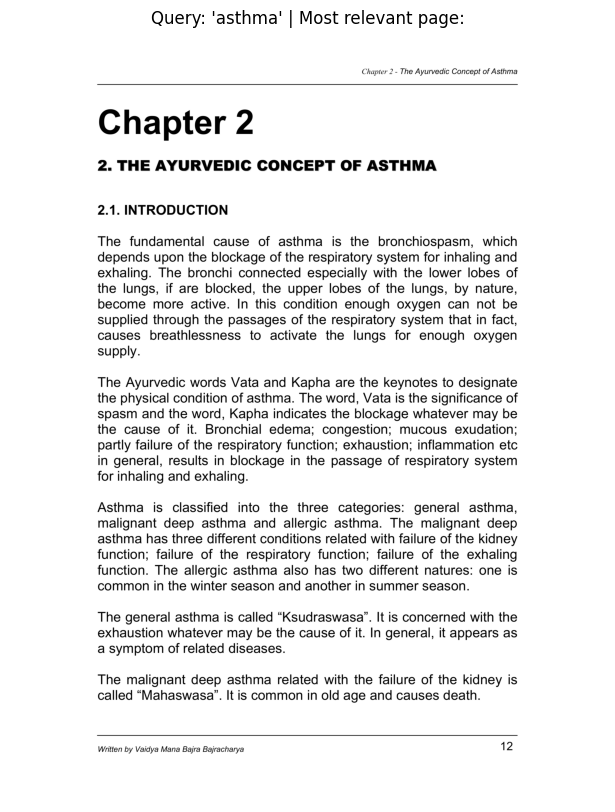

In [31]:
import fitz
import numpy as np
pdf_path="data1.pdf"
doc=fitz.open(pdf_path)
page=doc.load_page(10 + 1)
img=page.get_pixmap(dpi=300)

doc.close()
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

functionizing our semantic search pipline

In [32]:
def retrieve_relevant_resources(query:str,embeddings:torch.tensor,model:SentenceTransformer=embedding_model,n_resources_to_return: int=5,print_time: bool=True):
  #embed the query
  query_embedding=model.encode(query,convert_to_tensor=True)
  #Get dot product scores on embeddings
  start_time=timer()
  dot_scores=util.dot_score(query_embedding, embeddings)[0]
  end_time=timer()

  if print_time:
    print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    scores, indices=torch.topk(dot_scores, k=n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query: str,embeddings: torch.tensor,pages_and_chunks: list[dict]=pages_and_chunks,n_resources_to_return: int=5):
  scores, indices=retrieve_relevant_resources(query=query,embeddings=embeddings,n_resources_to_return=n_resources_to_return)

  #loop through zipped together scores and indices from torch.topk
  for score, idx in zip(scores, indices):
    print(f"Score:{score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number:{pages_and_chunks[idx]['page_number']}")
    print("\n")


In [33]:
query="asthma"
#retrieve_relevant_resources(query="asthma", embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (346 embeddings: 0.00007 seconds.
Score:0.6471
Text:
Chapter 2 - The Ayurvedic Concept of Asthma Written by Vaidya Mana Bajra
Bajracharya 12 Chapter 2 22..  TTH HEE  A AY YU UR RV VEED DIIC C  C CO ON NC
CEEPPTT  O OFF  A ASSTTH HM MA A 2.1. INTRODUCTION The fundamental cause of
asthma is the bronchiospasm, which depends upon the blockage of the respiratory
system for inhaling and exhaling. The bronchi connected especially with the
lower lobes of the lungs, if are blocked, the upper lobes of the lungs, by
nature, become more active. In this condition enough oxygen can not be supplied
through the passages of the respiratory system that in fact, causes
breathlessness to activate the lungs for enough oxygen supply. The Ayurvedic
words Vata and Kapha are the keynotes to designate the physical condition of
asthma. The word, Vata is the significance of spasm and the word, Kapha
indicates the blockage whatever may be the cause of it. Bronchial edema;
congest

#LLM for generate

In [34]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [35]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [36]:
torch.cuda.get_device_capability(0)[0]

7

In [37]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [38]:
!pip install huggingface_hub
!pip install ipywidgets
from huggingface_hub import notebook_login
notebook_login()

In [39]:
!pip install bitsandbytes accelerate

In [40]:
!pip install --upgrade transformers accelerate

In [41]:
!pip install --upgrade transformers

In [42]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above,
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 7):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [43]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [44]:
def get_model_num_params(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters())

get_model_num_params(llm_model)

2506172416

In [48]:
def get_model_num_size(model: torch.nn.Module):
  mem_params=sum([param.nelement()*param.element_size() for param in model.parameters()])
  mem_buffers=sum([buffer.nelement()*buffer.element_size() for buffer in model.buffers()])

  #calulate model sizes
  model_mem_bytes=mem_params+mem_buffers
  model_mem_mb=model_mem_bytes/(1024**2)
  model_mem_gb=model_mem_bytes/(1024**3)

  return{"model_mem_bytes":model_mem_bytes,
         "model_men_mb":round(model_mem_mb,2),
         "model_mem_gb":round(model_mem_gb,2)}

get_model_num_size(llm_model)

{'model_mem_bytes': 5012345344, 'model_men_mb': 4780.15, 'model_mem_gb': 4.67}

KNOWLEDGE GRAPH

In [46]:
from langchain.graphs import Neo4jGraph

In [ ]:
# Set up your Neo4j credentials
NEO4J_URL = ""  # Replace with your actual Neo4j URL
NEO4J_USERNAME = ""
NEO4J_PASSWORD = ""  # Replace with your actual password

# Initialize Neo4j graph connection
graph = Neo4jGraph(
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD
)

# Set up Groq LLM API (Replace with your actual API key)
GROQ_API_KEY = ""

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model_name="llama3-70b-8192",
    temperature=0.2
)

In [54]:
# Retrieve Neo4j Schema
schema = graph.get_schema

# Define the prompt template for generating Cypher queries
template = """
Task: Generate a Cypher statement to query the graph database.

Instructions:
- Use the exact relationship types and node labels from the schema.
- Return only relevant node properties.

Schema:
{schema}

Question: {question}
"""

question_prompt = PromptTemplate(
    template=template,
    input_variables=["schema", "question"]
)

# Set up the QA Chain
qa = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph,
    cypher_prompt=question_prompt,
    verbose=True,
    allow_dangerous_requests=True
)

Augumenting our prompt with context items

1.instruction
2.few example of input/output
3.give room to think

In [55]:
def prompt_formatter(query: str, context_items: list[dict], graph_info: str) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Check if the graph_info contains "I don't know" or similar
    if "don't know" in graph_info.lower() or "no information" in graph_info.lower():
        graph_info = "No relevant information was found in the knowledge graph."

    base_prompt = """Based on the following context items and knowledge graph information, please answer the query.
Give yourself room to think by extracting relevant passages from the context and knowledge graph before answering the query.
Don't return the thinking, only return the answer.
Make sure your answer are as explanatory as possible.
Use the following example as reference for the ideal answer style.

Example 1:
Query: What is the fundamental cause of migraine according to Ayurveda?
Answer: Ayurveda explains that the fundamental cause of migraine is the congestion and exudation from the cranial blood vessels affecting only one side of the head. This condition leads to a blockage in the function of bodily passages, causing severe headaches on the affected side.

Example 2:
Query: Why is hepatitis not considered to be caused by a virus in Ayurveda?
Answer: In Ayurveda, hepatitis is not attributed to a virus but rather to an imbalance in the body's doshas. It is primarily caused by anemic conditions and blood defects, which lead to different types of hepatitis, such as Pandukamala, Aupadravika Kamala, Kumbha Kamala, and Halimaka.

Example 3:
Query: What dietary restrictions are recommended for diabetic patients in Ayurveda?
Answer: Ayurveda advises diabetic patients to avoid sugar and sugarcane products, new rice, potatoes, greasy yogurt, newly made alcoholic beverages, and overeating. Additionally, an irregular eating schedule, lack of exercise, and a sedentary lifestyle should be avoided.

Now use the following context items and knowledge graph information to answer the query:
{context}

Knowledge Graph Information:
{graph_info}

Relevant passages: <extract relevant passages from the context and knowledge graph here>
User query: {query}
Answer:"""

    base_prompt = base_prompt.format(query=query, context=context, graph_info=graph_info)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user", "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
    return prompt

# Example usage
query = "What are the causes of Varicose Veins?"
print(f"Query: {query}")

# Get relevant resources from the context
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
context_items = [pages_and_chunks[idx] for idx in indices]

# Get relevant information from the knowledge graph
graph_response = qa.invoke({"query": query})
graph_info = graph_response['result']

# Check if the graph_info contains "I don't know" or similar
if "don't know" in graph_info.lower() or "no information" in graph_info.lower():
    graph_info = "No relevant information was found in the knowledge graph."

# Format our prompt
prompt = prompt_formatter(query=query, context_items=context_items, graph_info=graph_info)
print(f"Prompt: {prompt}")

Query: What are the causes of Varicose Veins?
[INFO] Time taken to get scores on (346 embeddings: 0.00006 seconds.


> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (d:Disease {name: "Varicose Veins"})<-[:CAUSES]-(c:Cause)
RETURN c.name, c.description

Full Context:
[{'c.name': 'Weak Nervous System', 'c.description': 'Overactive nerves cause veins to dilate abnormally and lose elasticity.'}, {'c.name': 'Loss of Blood', 'c.description': 'Weakens the nervous system, making veins more susceptible to dilation.'}, {'c.name': 'Blockage in Circulation', 'c.description': 'Poor blood flow prevents veins from returning to normal size.'}, {'c.name': 'Weak Digestion and Malnutrition', 'c.description': 'Lack of nutrients weakens vein walls and nervous function.'}, {'c.name': 'Pregnancy', 'c.description': 'Expanded uterus puts pressure on iliac veins, causing circulation issues.'}, {'c.name': 'Menopause and Heavy Menstruation', 'c.description': 'Hormonal changes and blood loss we

In [56]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
output=llm_model.generate(input_ids,
                          temperature=0.7,
                          do_sample=True,
                          max_new_tokens=256)

output_text=tokenizer.decode(output[0])
print(f"Query: {query}")
print(f"RAG answer: \m{output_text.replace(prompt, '')}")

Query: What are the causes of Varicose Veins?
RAG answer: \m<bos>The causes of varicose veins according to the passage are:

- Weak nervous system
- Loss of blood
- Blockage in circulation
- Weak digestion
- Pregnancy
- Menopause
- Heavy menstruation<eos>
CPU times: user 1.77 s, sys: 66.9 ms, total: 1.83 s
Wall time: 2.33 s


#Funtionize our LLM

In [57]:
def ask(query: str,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        format_answer_text: bool = True,
        return_answer_only: bool = True):
    # Retrieval
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    context_items = [pages_and_chunks[idx] for idx in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # Query the knowledge graph
    graph_response = qa.invoke({"query": query})
    graph_info = graph_response['result']

    # Check if the graph_info contains "I don't know" or similar
    if "don't know" in graph_info.lower() or "no information" in graph_info.lower():
        graph_info = "No relevant information was found in the knowledge graph."

    # Augmentation
    # Create the prompt and format it with context items and knowledge graph information
    prompt = prompt_formatter(query=query, context_items=context_items, graph_info=graph_info)

    # Generation
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")  # Move the input_ids tensor to cuda

    # Generate an output of tokens
    outputs = llm_model.generate(input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    if return_answer_only:
        return output_text
    return output_text, context_items

In [58]:
ask(query="What are the causes of Varicose Veins?")

[INFO] Time taken to get scores on (346 embeddings: 0.00006 seconds.


> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (d:Disease {name: "Varicose Veins"})<-[:CAUSES]-(c:Cause)
RETURN c.name, c.description

Full Context:
[{'c.name': 'Weak Nervous System', 'c.description': 'Overactive nerves cause veins to dilate abnormally and lose elasticity.'}, {'c.name': 'Loss of Blood', 'c.description': 'Weakens the nervous system, making veins more susceptible to dilation.'}, {'c.name': 'Blockage in Circulation', 'c.description': 'Poor blood flow prevents veins from returning to normal size.'}, {'c.name': 'Weak Digestion and Malnutrition', 'c.description': 'Lack of nutrients weakens vein walls and nervous function.'}, {'c.name': 'Pregnancy', 'c.description': 'Expanded uterus puts pressure on iliac veins, causing circulation issues.'}, {'c.name': 'Menopause and Heavy Menstruation', 'c.description': 'Hormonal changes and blood loss weaken veins.'}, {'c.name': 'Hanging Legs for Lo

'According to the context, the causes of varicose veins are:\n\n- **The weak nervous system** is the primary cause of varicose veins.\n- **Loss of blood**\n- **Blockage in the circulation**\n- **Weak digestion**\n- **Malnutrition**\n- **Pregnancy**\n- **Menopause** and **Heavy Menstruation**\n- **Hanging Legs for Long Periods**\n- **Old Age**\n- **Anxiety**\n- **Fear**'

In [59]:
ask(query="What are the symptoms of allergic asthma in Ayurveda?",
    temperature=0.2,
    return_answer_only=False)

[INFO] Time taken to get scores on (346 embeddings: 0.00007 seconds.


> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (d:Disease {name: "Allergic Asthma"})-[:HAS_SYMPTOM]->(s:Symptom)
RETURN s.name, s.description

Full Context:
[]

> Finished chain.


('Sure, here are the symptoms of allergic asthma in Ayurveda:\n\n- Difficulty for breathing or breathlessness\n- Uneasiness in the heart\n- Abnormal colic pain\n- Tympanitis or bloated stomach\n- Bad taste in the mouth\n- Slight headache\n- Difficulty for breathing, especially in the condition of exertion',
 [{'page_number': 14,
   'sentence_chunk': 'Chapter 2 - The Ayurvedic Concept of Asthma Written by Vaidya Mana Bajra Bajracharya 16 which causes blockage. Other causes of allergic asthma, which are related with heat result in inflammation, heat and congestion. In this condition heat is the main problem, which is identified as a Pittadosa, the Ayurvedic word to designate the dilatation or the veins, which cause heat. The allergic asthma whatever may be the kind of it, in general, gets worse in the condition of common cold, flue or congestion and the effect of darkness of night which results in slow activities of mind. 2.3. SYMPTOMS OF ASTHMA Difficulty for breathing or breathlessness

In [ ]:
test_data = [
    {
        "query": "What are the causes of Varicose Veins?",
        "answer": " The bodily grease and viscous elements often have been seen counteracted in the physical condition of the weak nervous system. There are many causes, which weakens the function of the nervous system. Some of them are: loss of blood; blockage in the circulation; weak digestion; malnutrition; nerve natured personality; old age; anxiety; fear etc."
    },
    {
        "query": "What triggers hay fever?",
        "answer": "These symptoms, in general, get worse in the daytime. The person who is allergic to pollen gets the annual recurrent attack of hay fever in the season of blossoming, spring. The person who is allergic to animal hair, dust gets the annual recurrent attack of hay fever in the season of rain, monsoon. The person who is allergic to clay dust gets the annual recurrent attack of hay fever in the dry and windy season."
    },
    {
        "query": "How can Pittavrita Vyana be prevented?",
        "answer": "Pittavrita Vyana, an Ayurvedic condition where Vyana Vayu becomes obstructed by aggravated Pitta, can lead to symptoms like inflammation, heat, and circulatory imbalances. To prevent this, adopting a balanced lifestyle is essential. Regular exercise ensures proper movement of Vyana Vayu, while avoiding clay-contaminated or rat-contaminated foods and drinking filtered water helps reduce Pitta-aggravating toxins. Wearing loose-fitting clothing prevents constriction and overheating, and immediate treatment of skin injuries or insect bites minimizes inflammation. Additionally, avoiding contradictory food combinations and maintaining hygiene by washing hands and nails properly prevents digestive and circulatory blockages."
    },
    {
        "query": "what is the treatment for Dry Haemorrhoid?",
        "answer": "The main purpose of the digestive medicine in the treatment of haemorrhoid is to activate the portal vein for proper function. Therefore, the digestive medicines such as Yavani."
    },
    {
        "query": "How can Pramehaja Sarsapi be prevented?",
        "answer": "No sexual intercourse during the period of infection. It is very important to pay attention. Not to have recurrent infection, herpes should be treated as soon as possible. Tight underwear is prohibited. It causes wet, which is one of the aggravating causes of infection. The condition of acidosis of blood should be fixed as soon as possible. Pure blood should be alkaline in reaction. Sleeping during the day, especially after meal, is strictly prohibited. It causes exudation, which is one of the aggravating causes of infection. Distressing or angry mood should be counteracted with delicious food, music and friendly entertainment. Kissing is prohibited when still cold sore has not well healed. Urinary diseases should be treated well with proper diet."
    },
    {
        "query": "What can be treated for allergic asthma?",
        "answer": "Swasakasantaka, a compound of Adhatoda vasica with other ingredients, is one of the best remedies against asthma to counter the problems of blockage and spasm."
    },
    {
        "query": "What are the causes of Pittaja-Granthi?",
        "answer": "Pittaja-Granthi, a type of inflammatory growth or cystic condition in Ayurveda, arises due to aggravated Pitta dosha affecting the blood and tissues, leading to painful, swollen, and often suppurating lesions. The primary causes include chronic inflammation and skin injuries like cutaneous white tissue damage, which disturb Pitta’s balance. Exposure to harsh chemicals, contaminated water, or rat urine introduces toxins that further aggravate Pitta. Dietary factors, such as incompatible food combinations, generate internal toxins, while improper treatment of bleeding disorders can lead to abnormal tissue growth. Additionally, insect bites, slow poison accumulation, and unpurified toxic medicines contribute to Pitta-dominated abscesses or tumors."
    },
    {
        "query": "What is the recommended diet for Dhatuksayaja Madhumeha?",
        "answer": "The foundation of this diet includes barley and millets like ragi, which provide slow-releasing carbohydrates and help stabilize glucose levels. Bitter vegetables such as bitter gourd, fenugreek leaves, and ash gourd are essential for their blood-sugar-lowering properties, while mung bean soup and whole-wheat chapati offer easily digestible proteins and fibers. For non-vegetarians, eggs and lean wild bird meat can help rebuild depleted tissues, though heavy meats should be avoided. Hydration is crucial, with boiled and filtered water being the best choice, supplemented by herbal infusions like fenugreek or cinnamon tea."
    },
    {
        "query": "what is the treatment for Migraine (Ardhavabhedaka)?",
        "answer": "Guggulu, the resin of Balsamodendron mukul is one of the best remedies for dilations of cranial capillaries."
    },
    {
        "query": "What are the treament of Kitibha?",
        "answer": "Psoriasis treatment focuses on three approaches: blood purification, skin healing, and balancing artery/nervous system functions. The disease stems from blood toxicity, treated with Gandhaka Rasayana for 3-6 months or bloodletting in severe cases. Skin lesions are addressed with Vakuchyadi Vati and Shorea robusta resin ointment. For systemic balance, Kaisara Guggulu regulates mucous membranes and nerves. These therapies work synergistically for holistic recovery."
    }
]


In [ ]:
generated_answers = []
for item in test_data:
    generated_answer = ask(item["query"])
    generated_answers.append({"query": item["query"], "generated_answer": generated_answer})

[INFO] Time taken to get scores on (346 embeddings: 0.00006 seconds.


> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (d:Disease {name: "Varicose Veins"})<-[:CAUSES]-(c:Cause)
RETURN c.name, c.description

Full Context:
[{'c.name': 'Weak Nervous System', 'c.description': 'Overactive nerves cause veins to dilate abnormally and lose elasticity.'}, {'c.name': 'Loss of Blood', 'c.description': 'Weakens the nervous system, making veins more susceptible to dilation.'}, {'c.name': 'Blockage in Circulation', 'c.description': 'Poor blood flow prevents veins from returning to normal size.'}, {'c.name': 'Weak Digestion and Malnutrition', 'c.description': 'Lack of nutrients weakens vein walls and nervous function.'}, {'c.name': 'Pregnancy', 'c.description': 'Expanded uterus puts pressure on iliac veins, causing circulation issues.'}, {'c.name': 'Menopause and Heavy Menstruation', 'c.description': 'Hormonal changes and blood loss weaken veins.'}, {'c.name': 'Hanging Legs for Lo

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d83ff7af0e5787aed6761e8515bca9250eacd2ffcbbbf11599bd4ca3e6e7dd6f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rougeL'], use_stemmer=True)

In [ ]:
for i in range(len(test_data)):
    reference = test_data[i]["answer"]
    hypothesis = generated_answers[i]["generated_answer"]
    scores = scorer.score(reference, hypothesis)

    print(f"\nQuery: {test_data[i]['query']}")
    print(f"Reference Answer: {reference}")
    print(f"Generated Answer: {hypothesis}")
    print(f"ROUGE-1: {scores['rouge1']}")
    print(f"ROUGE-2: {scores['rouge2']}")
    print(f"ROUGE-3: {scores['rouge3']}")
    print(f"ROUGE-4: {scores['rouge4']}")
    print(f"ROUGE-L: {scores['rougeL']}")


Query: What are the causes of Varicose Veins?
Reference Answer:  The bodily grease and viscous elements often have been seen counteracted in the physical condition of the weak nervous system. There are many causes, which weakens the function of the nervous system. Some of them are: loss of blood; blockage in the circulation; weak digestion; malnutrition; nerve natured personality; old age; anxiety; fear etc.
Generated Answer: Sure, here are the relevant passages from the context and knowledge graph:

**From the context:**

* The weak nervous system is a key cause of varicose veins.
* The veins attached with the weak nervous system become overactive and can be seen dilated in abnormal ways.
* The dilated veins while having relaxation, have to assume the normal position.
* This is the nature because the wall of the veins has the elastic physical properties.

**From the knowledge graph:**

* The causes of Varicose Veins are Weak Nervous System, Loss of Blood, Blockage in Circulation, Wea